## Домашнее задание №2: Глубинные нейронные сети. Pytorch

### Пожалуйста, заполните имя

In [0]:
STUDENT_NAME = "Ruslan Sungatullin"

In [0]:
# Включает режим проверки
try:
    import train_utils
    TEST_MODE = True
except:
    TEST_MODE = False

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os
from skimage import io, transform
from IPython.display import clear_output
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn import MSELoss, Sequential, Linear, Sigmoid, Tanh
import torch.nn as nn
from torch import Tensor
%matplotlib inline

**Не удаляйте клетки из этого jupyter-notebok! Это затруднит проверку!**

В этом задании вам предстоит попробовать обучить нейронную сеть с помощью фреймворка Pytorch, изучить подходы к инициализации нейронных сетей и реализовать слои, улучшающие сходимость глубинных нейронных сетей.

### Часть 1. Введение в Pytorch

Используя датасет из архива решите задачу регрессии для поиска 68-ми ключевых точек лица.  
Для обучения и валидации используйте изображения и разметку из папок train и test соответственно.  

Image name: 105.jpeg
Landmarks shape: (68, 2)
First 4 Landmarks: [[10. 36.]
 [11. 46.]
 [13. 55.]
 [15. 64.]]


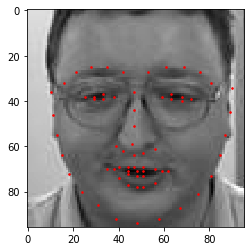

In [0]:
# Пример работы с датасетом

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

landmarks_frame = pd.read_csv('dataset/train/face_landmarks.csv')

n = 56
img_name = landmarks_frame.ix[n, 0]
landmarks = landmarks_frame.ix[n, 1:].as_matrix().astype('float')
landmarks = landmarks.reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image, cmap='gray')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='red', cmap='rgb')
    plt.pause(0.001)  

plt.figure()
show_landmarks(io.imread(os.path.join('dataset/train/', img_name)),
               landmarks)
plt.show()

In [0]:
image = io.imread(os.path.join('dataset/train/', img_name))
image.shape

(96, 96)

In [0]:
96**2

9216

In [0]:
landmarks_frame.tail()

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,part_4_y,part_5_x,part_5_y,part_6_x,part_6_y,part_7_x,part_7_y,part_8_x,part_8_y,part_9_x,part_9_y,part_10_x,part_10_y,part_11_x,part_11_y,part_12_x,part_12_y,part_13_x,part_13_y,part_14_x,part_14_y,part_15_x,part_15_y,part_16_x,part_16_y,part_17_x,part_17_y,part_18_x,part_18_y,part_19_x,...,part_48_x,part_48_y,part_49_x,part_49_y,part_50_x,part_50_y,part_51_x,part_51_y,part_52_x,part_52_y,part_53_x,part_53_y,part_54_x,part_54_y,part_55_x,part_55_y,part_56_x,part_56_y,part_57_x,part_57_y,part_58_x,part_58_y,part_59_x,part_59_y,part_60_x,part_60_y,part_61_x,part_61_y,part_62_x,part_62_y,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
6216,994.jpeg,10,41,11,50,13,59,15,68,19,77,25,84,33,90,42,94,52,95,61,93,68,87,74,80,78,72,79,63,80,55,81,46,81,38,17,30,22,27,28,...,36,74,41,70,47,68,51,69,54,68,60,69,65,71,60,75,56,78,52,78,47,78,42,77,38,73,47,72,51,72,55,72,63,71,55,72,51,73,47,73
6217,995.jpeg,4,33,5,44,7,55,8,66,11,76,17,85,26,92,36,97,47,97,58,96,66,91,72,83,77,74,79,64,81,54,83,44,84,35,11,27,18,23,26,...,32,75,39,73,45,72,49,73,53,72,57,73,62,76,57,80,52,82,48,83,44,82,38,80,35,75,44,75,49,76,53,75,60,76,52,76,48,77,44,76
6218,997.jpeg,4,52,4,62,6,72,8,82,11,90,18,96,28,98,38,98,49,98,60,98,71,97,80,94,86,88,88,79,90,70,91,61,91,50,12,32,17,26,25,...,29,81,36,75,44,72,48,73,53,72,60,75,68,81,61,85,53,86,49,87,44,86,36,85,32,81,44,78,48,78,53,78,64,81,53,80,49,80,44,80
6219,998.jpeg,9,42,9,52,10,62,11,72,14,82,19,90,26,95,36,99,46,99,57,99,66,96,73,90,78,82,81,72,83,63,84,53,85,42,14,34,19,27,27,...,32,79,37,76,43,74,47,75,51,74,57,76,62,79,57,83,51,84,47,84,42,84,37,83,34,78,43,77,47,78,51,77,60,79,51,80,47,80,43,79
6220,999.jpeg,8,38,8,49,9,59,10,70,14,79,19,88,26,94,35,97,46,97,56,97,65,94,72,89,77,81,81,71,83,62,86,51,87,41,13,29,18,23,25,...,35,83,39,81,43,80,46,81,49,80,53,82,58,85,53,87,49,87,46,87,43,87,39,86,37,83,43,83,46,83,49,83,55,84,49,81,46,82,43,81


In [0]:
landmarks_frame.shape

(6221, 137)

In [0]:
# Далее нам нужно сформировать свой датасет
# См. https://pytorch.org/docs/stable/torchvision/datasets.html

class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    # Из этой функции нужно вернуть dict вида {'image': image, 'landmarks': landmarks}
    # Где image и landmarks - получаются так же, как в функции выше
    # Не забудьте применить transform - это нужно для превращения в тензор
    def __getitem__(self, idx):
        result = dict()
        img_name = self.landmarks_frame.ix[idx, 0]
        landmarks = self.landmarks_frame.ix[idx, 1:].as_matrix().astype('float')
        landmarks = landmarks.reshape(-1, 2)
        result['image'] = io.imread(os.path.join(self.root_dir, img_name))
        result['landmarks'] = landmarks
        return result if self.transform is None else self.transform(result)

In [0]:
# Превращение в torch.Tensor лучше делать как отдельное преобразование -
# это позволит работать с датасетом не только в рамках pytorch
# Выходом преобразования должны быть (X, y) - 2 одномерных тензора torch.FloatTensor
# Для этого воспользуйтеь методом ndarray.ravel()
# Получающиеся размерности X = torch.Size([9216]), y = torch.Size([136])

# Обратите внимание на типы тензоров в pytorch! Это очень важный их параметр!
# См. https://pytorch.org/docs/stable/tensors.html#torch.Tensor.type

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    # Превращает во FloatTensor входные данные и "вытягивает" размерности в одну строку
    # (т.к. у нас не сверточные сети - нет смысла хранить размерности)
    def __call__(self, sample):
        X = torch.FloatTensor(sample["image"]).reshape(-1)
        y = torch.FloatTensor(sample["landmarks"]).reshape(-1)
        return (X, y)

In [0]:
# Если не отделять папку dataset от этого notebook, то этот код
# 1) должен создать train и test
train_dataset = FaceLandmarksDataset(csv_file='dataset/train/face_landmarks.csv',
                                     root_dir='dataset/train',
                                     transform=ToTensor() # Чтобы получить тензоры
                                     )
test_dataset = FaceLandmarksDataset(csv_file='dataset/test/face_landmarks.csv',
                                     root_dir='dataset/test',
                                     transform=ToTensor()
                                     )

# 2) сформировать dataloader-ы 
# См. https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=64,
                        shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64,
                        shuffle=True)

Попробуйте сети глубины 1 и 2 и разные активации (ELU, RELU и sigmoid). Loss - MSE, оптимизатор - Adam с learning rate 0.1 (остальные параметры оптимизатора по умолчанию). Обучайте сети в течении 4 эпох - нам не нужно здесь качество  
Для каждой архитектуры постройте графики для функции потерь на train/test


В этом задании **нет** порога качества - оно нужно, чтобы освоиться с pytorch

In [0]:
def simple_train(network, train_dataloader, test_dataloader, epochs):
  optimizer = torch.optim.Adam(network.parameters(), lr=0.1)
  loss = MSELoss().cuda()
  train_loss = []
  test_loss = []
  for e in range(epochs):
    losses = []
    for X, y in train_dataloader:
      prediction = network(X.cuda())
      mse = loss(prediction, y.cuda())
      losses.append(mse.item())
      optimizer.zero_grad()
      mse.backward()
      optimizer.step()
    train_loss.append(np.mean(losses))
    losses = []
    for X, y in test_dataloader:
      prediction = network(X.cuda())
      mse = loss(prediction, y.cuda())
      losses.append(mse.item())
    test_loss.append(np.mean(losses))
    clear_output(True)
    plt.plot(train_loss, label="Train")
    plt.plot(test_loss, label="Test")
    plt.legend()
    plt.show()
  print(network)
  print("TRAIN MSE: {0}".format(np.min(train_loss)))
  print("TEST MSE: {0}".format(np.min(test_loss)))
  return train_loss, test_loss

In [0]:
# Массив из nn.Sequential - сетей для обучения
networks = [nn.Sequential(nn.Linear(9216, 1000), nn.Sigmoid(), nn.Linear(1000, 136)).cuda(),
            nn.Sequential(nn.Linear(9216, 1000), nn.ReLU(), nn.Linear(1000, 136)).cuda(),
            nn.Sequential(nn.Linear(9216, 1000), nn.ELU(), nn.Linear(1000, 136)).cuda()]

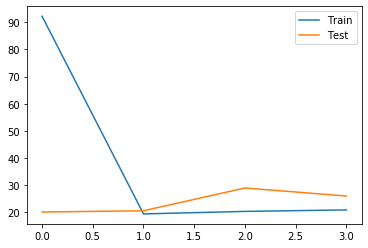

Sequential(
  (0): Linear(in_features=9216, out_features=1000, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=1000, out_features=136, bias=True)
)
TRAIN MSE: 19.4257931222721
TEST MSE: 20.131421585083007


In [0]:
# Должен построить графики и написать значение MSE на train и test для каждой из архитектур
simple_train(networks[0], train_dataloader, test_dataloader, 4)

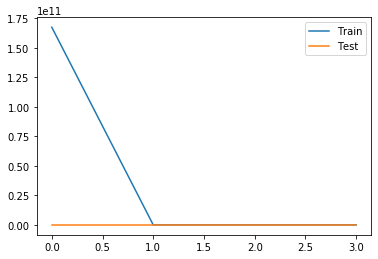

Sequential(
  (0): Linear(in_features=9216, out_features=1000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=136, bias=True)
)
TRAIN MSE: 3321.871464943399
TEST MSE: 3308.986494140625


([167407740844.3049, 3323.792089345504, 3324.2708366549746, 3321.871464943399],
 [3309.54541015625, 3309.579990234375, 3309.72724609375, 3308.986494140625])

In [0]:
# Должен построить графики и написать значение MSE на train и test для каждой из архитектур
simple_train(networks[1], train_dataloader, test_dataloader, 4);

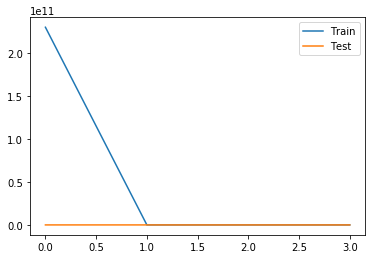

Sequential(
  (0): Linear(in_features=9216, out_features=1000, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=1000, out_features=136, bias=True)
)
TRAIN MSE: 16412.128059231505
TEST MSE: 12668.8040625


In [0]:
# Должен построить графики и написать значение MSE на train и test для каждой из архитектур
simple_train(networks[2], train_dataloader, test_dataloader, 4);

In [0]:
# Проверка
if TEST_MODE:
    from importlib import reload
    reload(train_utils)

    for n in networks:
        train_utils.train(n, train_dataloader, test_dataloader, 4, MSELoss())

In [0]:
# Посмотрим на предикт

def show_landmarks_batch(sample_batch, y_pred=None):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = sample_batch
    batch_size = len(images_batch)

    images_batch = images_batch.view(-1, 96, 96)
    landmarks_batch = landmarks_batch.view(-1, 68, 2)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose(1,0,2).reshape(im_size, -1), cmap="gray")

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r', label='Real')

    if type(y_pred) != type(None):
        for i in range(batch_size):
            plt.scatter(y_pred[i, :, 0] + i * im_size,
                        y_pred[i, :, 1],
                        s=10, marker='.', c='b',  label='Prediction')
        plt.title('Batch from dataloader')
    plt.legend()

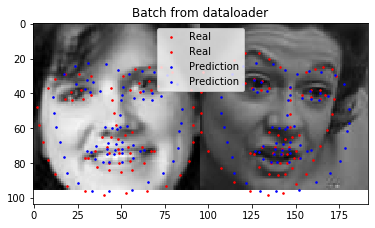

In [0]:
final_nw_pos = 0 # Выберите номер лучшей архитектуры в списке networks

test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)
batch = next(iter(test_dataloader))
x = batch[0]
y_pred = networks[0].cuda()(x.cuda())
y = batch[1]
y_pred = y_pred.view(-1, 68, 2)
y_pred = y_pred.data.cpu().numpy()
show_landmarks_batch(batch, y_pred)

### Часть 2. Инициализация нейронных сетей
В этом задании мы вернемся к нашему знакомому датасету MNIST. Напомним:

In [0]:
from torchvision.datasets import MNIST

to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [0]:
# Тестовые батчи. Нарисуем их, а потом будем пропускать их через нейронную сеть
images_train, labels_train = next(iter(train_loader))

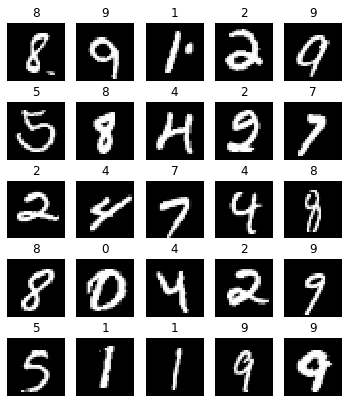

In [0]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images_train.numpy()[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(labels_train.numpy()[i])
    plt.axis('off')

In [0]:
# Нам понадобятся некоторые вспомогательные функции для распечатки градиентов

ITER = 0
def forward_hook(self, input_, output):
    global ITER
    std = input_[0].std().item()
    print(ITER, ': forward', std)
    ITER += 1

def backward_hook(self, grad_input, grad_output):
    global ITER
    std = grad_input[0].std().item()
    print(ITER, ': backward', std)
    ITER -= 1

# Пользоваться ими можно так (пример функтора создания слоя)
def create_sample_linear(inp_size, out_size):
    layer = nn.Linear(inp_size, out_size)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=0.1)
    return layer

In [0]:
# Функция пропуска тестового батча через нейронную сеть
def sample_propagation(network):
    global ITER
    ITER = 0

    n_objects = 100
    X = images_train[:n_objects].view(n_objects, -1)
    y = labels_train[:n_objects]
    print(X.shape, y.shape)

    activations = network(X)
    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
    loss = loss_fn(activations, y)
    loss.backward()

In [0]:
# Функция создания тестовой нейронной сети. Следует создавать 200 промежуточных слоев (и activation между ними)
# Принимает функторы создания слоев с "говорливыми" hook-ами (см. пример функтора создания слоя выше),
# возвращает nn.Sequential из них
# Не забывайте про *list для распаковки списков в параметры

# layers_creator - принимает массив, добавляет в него новый линейный промежуточный слой 500x500
# start_layer_creator - принимает массив, добавляет в него первый слой (784 --> 500)
# end_layer_creator - принимает массив, добавляет в него последний слой (500 --> 10)

def create_network(layers_creator,
                   start_layer_creator=lambda layers: layers.append(create_sample_linear(784, 500)),
                   end_layer_creator=lambda layers: layers.append(create_sample_linear(500, 10)),
                   activation=nn.Tanh()):
  layers = []
  start_layer_creator(layers)
  layers.append(activation)
  for i in range(200):
    layers_creator(layers)
    layers.append(activation)
  end_layer_creator(layers)
  return nn.Sequential(*layers)

Сделайте функторы создания слоев (линейных, 500x500):  
1. Инициализированных N(0, 0.1) - см. create_sample_linear
2. Инициализированных по He
3. Инициализированных по Xavier

Обучите нейронные сети с каждым из методов инициализации. Архитектура - 784 -> 500 x (200 раз) -> 10. В качестве активации возьмите tanh (1-2), ReLU (Xavier). Посмотрите как изменяются градиенты на forward и backward (с помощью sample_propagation). Сделайте выводы

In [0]:
def create_layer_normal(layers):
  layers.append(create_sample_linear(500, 500))

def create_layer_He(layers):
  layer = nn.Linear(500, 500)
  layer.register_forward_hook(forward_hook)
  layer.register_backward_hook(backward_hook)
  
  weight = layer.state_dict()['weight']
  bias = layer.state_dict()['bias']
  bias.zero_()
  nn.init.kaiming_normal_(weight)
  layers.append(layer)

def create_layer_Xavier(layers):
  layer = nn.Linear(500, 500)
  layer.register_forward_hook(forward_hook)
  layer.register_backward_hook(backward_hook)
  
  weight = layer.state_dict()['weight']
  bias = layer.state_dict()['bias']
  bias.zero_()
  nn.init.xavier_normal_(weight)
  layers.append(layer)

In [0]:
network = create_network(create_layer_normal)
sample_propagation(network)

torch.Size([100, 784]) torch.Size([100])
0 : forward 0.9845987558364868
1 : forward 0.8450946807861328
2 : forward 0.7885957956314087
3 : forward 0.76790452003479
4 : forward 0.7653449773788452
5 : forward 0.7679742574691772
6 : forward 0.7674707770347595
7 : forward 0.7666206359863281
8 : forward 0.7656605243682861
9 : forward 0.7643775343894958
10 : forward 0.7658628225326538
11 : forward 0.7677329182624817
12 : forward 0.7678034901618958
13 : forward 0.7649062871932983
14 : forward 0.765291154384613
15 : forward 0.7637462019920349
16 : forward 0.7658584713935852
17 : forward 0.7650783658027649
18 : forward 0.7637476325035095
19 : forward 0.7653577923774719
20 : forward 0.7669382095336914
21 : forward 0.7658181190490723
22 : forward 0.7654592394828796
23 : forward 0.7631933093070984
24 : forward 0.7659008502960205
25 : forward 0.7646448612213135
26 : forward 0.7644523978233337
27 : forward 0.7646770477294922
28 : forward 0.7646402716636658
29 : forward 0.7640531659126282
30 : forward

In [0]:
network = create_network(create_layer_He)
sample_propagation(network)

torch.Size([100, 784]) torch.Size([100])
0 : forward 0.9845987558364868
1 : forward 0.8474602699279785
2 : forward 0.6797182559967041
3 : forward 0.6124183535575867
4 : forward 0.5841575860977173
5 : forward 0.5712714791297913
6 : forward 0.5685823559761047
7 : forward 0.5655453205108643
8 : forward 0.5565842986106873
9 : forward 0.5600366592407227
10 : forward 0.5595894455909729
11 : forward 0.5579555630683899
12 : forward 0.5584192276000977
13 : forward 0.5557846426963806
14 : forward 0.5593675374984741
15 : forward 0.5608079433441162
16 : forward 0.5565912127494812
17 : forward 0.5577861666679382
18 : forward 0.5564475059509277
19 : forward 0.5536730289459229
20 : forward 0.5573155879974365
21 : forward 0.5559350848197937
22 : forward 0.5557456612586975
23 : forward 0.5514350533485413
24 : forward 0.5552306175231934
25 : forward 0.5530962944030762
26 : forward 0.5547246932983398
27 : forward 0.5531933307647705
28 : forward 0.5517854690551758
29 : forward 0.5507497191429138
30 : forw

In [0]:
network = create_network(create_layer_Xavier, activation=nn.ReLU())
sample_propagation(network)

torch.Size([100, 784]) torch.Size([100])
0 : forward 0.9845987558364868
1 : forward 1.6598230600357056
2 : forward 1.1705580949783325
3 : forward 0.798831582069397
4 : forward 0.5337159037590027
5 : forward 0.369162380695343
6 : forward 0.26026806235313416
7 : forward 0.18403542041778564
8 : forward 0.12716296315193176
9 : forward 0.0885709822177887
10 : forward 0.06458115577697754
11 : forward 0.04839059337973595
12 : forward 0.034095507115125656
13 : forward 0.0242996197193861
14 : forward 0.017680754885077477
15 : forward 0.011565220542252064
16 : forward 0.0075827050022780895
17 : forward 0.005506263114511967
18 : forward 0.003673311322927475
19 : forward 0.002693681977689266
20 : forward 0.0018357924418523908
21 : forward 0.0012432687217369676
22 : forward 0.0009275496122427285
23 : forward 0.0006538848974741995
24 : forward 0.0004758455906994641
25 : forward 0.00033973148674704134
26 : forward 0.00022961867216508836
27 : forward 0.00017597322585061193
28 : forward 0.0001201561535

*Выводы:*
От инициализации весов зависит дисперсия входных данных в forward и backward. При использовании Xavier инициализации дисперсия близка к нулю.

Спасибо за выполнение заданий!  

**Обратите внимание:**  
Еще 2 обязательных задания этого модуля - batchnorm и dropout - находятся в следующем jupyter notebook (скоро будет отправлен). Также будет отправлено необязательное задание по методам оптимизации